## Lotka-Volterra System and Limit Cycles

The [Lotka–Volterra](#ref1) equations, also known as the predator–prey equations, are a pair of first-order nonlinear differential equations, frequently used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey. The populations change through time according to the pair of equations:

$$
 \begin{gather} \tag{1}
    \begin{aligned}
        \frac{dx}{dt} = αx - βxy \\
        \frac{dy}{dt} = δxy - γy
    \end{aligned}
\end{gather}
$$

In [2]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
def create_lotka_volterra_dataset(tmax, dt):

    # Dynamics of The Model
    def lotka_volterra(t, z, alpha, beta, gamma, delta):
        x, y = z
        dx_dt = alpha * x - beta * x * y
        dy_dt = -gamma * y + delta * x * y
        return [dx_dt, dy_dt]

    # Lorenz paramters and initial conditions.
    alpha, beta, gamma, delta = 1.0, 0.1, 1.5, 0.75
    x0, y0 = 10.0, 5.0

    # Integrate the Lotka Volterra equations.
    sol = solve_ivp(lotka_volterra, [0, tmax], [x0, y0], args=(alpha, beta, gamma, delta), dense_output=True)

    # Interpolate solution onto the time grid, t.
    t = np.linspace(0, tmax, dt)
    X = sol.sol(t)

    return t, X

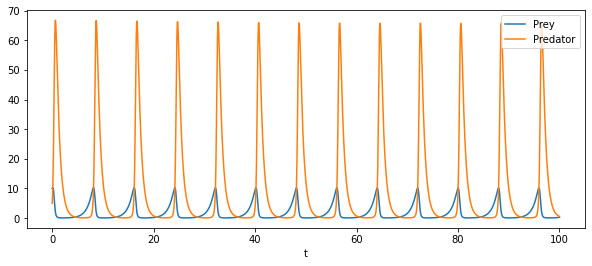

In [3]:
def show_lotka_volterra(t, Z):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    ax.plot(t, Z[0], linestyle='solid', label="Prey")
    ax.plot(t, Z[1], linestyle='solid', label="Predator")
    ax.set_xlabel("t")
    plt.legend(loc=1)
    plt.show()

tmax = 100
dt = 10000

t, Z = create_lotka_volterra_dataset(tmax, dt)
show_lotka_volterra(t, Z)

## Forecasting Time-Series via Recurrent Neural Networks (RNNs)

In [4]:
import random
import torch
from torch import nn

class RNNLayer(nn.Module):
    """RNN Layer

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms. 
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.tanh(self.input2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        # Loop through time
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)
        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden

class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        self.rnn = RNNLayer(input_size, hidden_size, **kwargs)
        self.do = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

        # Default mode is teacher forcing
        self.teacher_forcing_ratio = 0.0

    def forward(self, x, hidden=None):
        use_teacher_forcing = True if random.random() > self.teacher_forcing_ratio else False
        if use_teacher_forcing:
            rnn_output, _ = self.rnn(x)
            if enable_do:
                rnn_output = self.do(rnn_output)
            out = self.fc(rnn_output)
            return out, rnn_output
        else:
            # If hidden activity is not provided, initialize it
            if hidden is None:
                hidden = self.rnn.init_hidden(input.shape).to(input.device)

            rnn_output = []
            x_t = input[0]
            # Loop through time
            for i in range(input.size(0)):
                hidden = self.rnn.recurrence(x_t, hidden)
                rnn_output.append(hidden)
                if enable_do:
                    hidden = self.do(hidden)
                x_t = self.fc(hidden)
            # Stack together output from all time steps
            output = torch.stack(rnn_output, dim=0)  # (seq_len, batch, hidden_size)
            if enable_do:
                rnn_output = self.do(rnn_output)
            out = self.fc(output)
            return out, rnn_output


## Define the Dataset

In [5]:
def normalize(data, train_set=None):
    """
    Scale data to range (0,1) accodring to minimum and maximum of data
    """
    if train_set==None:
        train_set = data
    return (data-train_set.min(axis=0))/(train_set.max(axis=0)-train_set.min(axis=0))

In [6]:
# Discard % of Data
split_ratio = 0.5
split_index = int(split_ratio * len(t))
t = t[split_index:]
X = Z[0][split_index:]

# Normalize the Data
X = normalize(X)

# The input to the RNN is a time-delay-embedded matrix of X(t) with embedding dimension q (also known as lookback; Kim et al., 1999).
q = 10
X_train = np.expand_dims(X, axis=1)
X_train_step = np.zeros((q, len(t)-q, 1))
for s in range(len(X)-q):
    for step in range(q-1, -1, -1):
        X_train_step[step, s, :] = X_train[s+q-step-1, :]
Y_train = X[q:]

# X has the form nsteps x samples x input_dim
# Y has the form samples x input_dim
X_train_step = torch.from_numpy(X_train_step).type(torch.float)
X_train_step_ss = torch.clone(X_train_step)
Y_train = torch.from_numpy(Y_train).type(torch.float)

## Train the Recurrent Neural Network (RNN) via Teacher-forcing

Teacher forcing is a technique that is frequently used in dynamical supervised learning tasks where the model (student) receives the ground truth output $d(t)$ (teacher) in the subsequent computation of the behaviour of the network. In our context, this framework allows us to design tasks that we understand perfectly, and since the teacher and student are both neural networks with the same activation function, we also know that the student is, in principle, capable of imitating the teacher flawlessly.

In [7]:
# Set flags
enable_do = False       # Use a DropOut Layer
enable_sgd = False      # Use Stochastic Gradient Descent as Optimizer
enable_adam = True      # Use the Adam Optimizer
shuffle = True

In [8]:
# Init RNN model
hidden_dim = 200
net = RNNNet(1, hidden_dim, 1)

if enable_sgd:
    optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)
if enable_adam:
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss_func = nn.MSELoss()

# Number of iterations treated as burn-in
burn_in_period = 100

for epoch in range(1000):

    data = X_train_step[:,burn_in_period:,:]
    
    if not shuffle:
        # Reset State and Burn-in
        net(X_train_step[:,0:burn_in_period,:])
    else:
        idx = torch.randperm(data.shape[0])
        data = data[idx].view(data.size())

    optimizer.zero_grad()
    input = data
    pred, _ = net(input)

    loss = loss_func(pred[q-1,:,0], Y_train[burn_in_period:])
    loss.backward()
    optimizer.step()

    if epoch%20==0:
        print(epoch, loss.data.item())

0 0.29056283831596375
20 0.008231783285737038
40 0.0010728792985901237
60 0.00022278906544670463
80 0.0008866251446306705
100 0.0017762354109436274
120 0.0009329957538284361
140 0.0015175639418885112
160 0.0015224518720060587
180 0.0012093589175492525
200 0.0004984767292626202
220 0.00104395835660398
240 0.0005215305718593299
260 0.0019809033256024122
280 0.001031119842082262
300 0.0016360675217583776
320 0.0017018525395542383
340 0.001000589574687183
360 0.0005461546825245023
380 0.0001191370320157148
400 0.001348862424492836
420 0.00046397268306463957
440 5.045521538704634e-05
460 0.00034091819543391466
480 0.0003567658714018762
500 0.0012511868262663484
520 0.0005683570052497089
540 0.0007452836725860834
560 0.00021148820815142244
580 0.0010421044426038861
600 0.0004227092140354216
620 0.0019275083905085921
640 0.0009215051541104913
660 0.0007043477962724864
680 0.0008150473586283624
700 0.0009264110121876001
720 0.0012704645050689578
740 0.0002808747813105583
760 0.0013843266060575

In [9]:
def plot_time_series(true, pred, label):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    ax.plot(true, label="True")
    ax.plot(pred, label="Pred")
    ax.set_xlabel("t")
    ax.legend(loc=1)
    ax.set_title(label)
    plt.show()

## Generate the Recurrent Neural Network (RNN) Predictions at Training Points

0.001745659


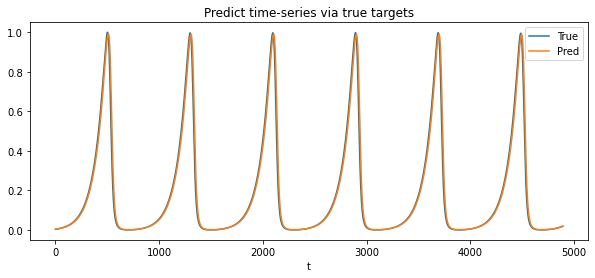

In [10]:
# Reset State & Burn-in
net(X_train_step[:,0:burn_in_period,:])

# Predict time-series via true targets
pred, _ = net(X_train_step[:,burn_in_period:,:])

# Compute loss
error = loss_func(pred[-1,:,:].view(-1), Y_train[burn_in_period:]).detach().numpy()
print(error)

# Plot predictions
plot_time_series(X[burn_in_period+q:], pred[-1,:,:].view(-1).detach().numpy(), "Predict time-series via true targets")

## Forecasting the time-series with a seed input

0.51584023


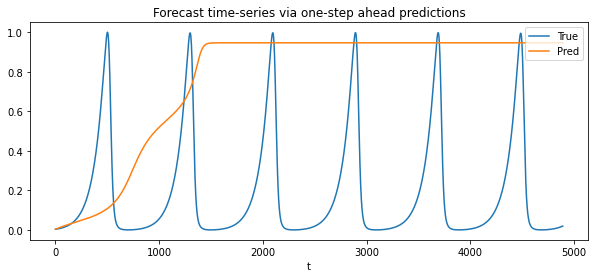

In [11]:
def one_step_ahead(net, data, n_predictions):
    """
    Generally, time series forecasting describes predicting the observation at the next time step. This is called a one-step forecast.
    The recursive strategy involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.
    """
    pred = []
    for _ in range(n_predictions):
        y_t, _ = net.forward(data)
        data[0:q-1,:,:] = data[1:q,:,:].clone()
        data[q-1,:,:] = y_t[q-1,:,:]
        pred.append(data.detach().numpy()[-1,0,0])
    return pred

# Reset State & Burn-in
net(X_train_step[:,0:burn_in_period,:])

# Forecast time-series via one-step ahead predictions
data = X_train_step[0:q,0+burn_in_period:1+burn_in_period,:]
one_step = one_step_ahead(net, data, X_train_step[:,burn_in_period:,:].shape[1])
one_step = np.asarray(one_step)

# Compute loss
error = loss_func(torch.from_numpy(one_step), Y_train[burn_in_period:]).detach().numpy()
print(error)

# Plot predictions
plot_time_series(X[burn_in_period+q:], one_step, "Forecast time-series via one-step ahead predictions")

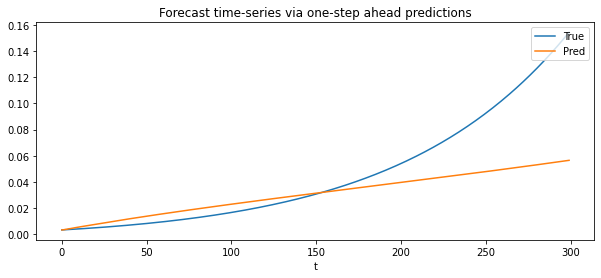

In [12]:
# Plot predictions
len = 300
plot_time_series(X[burn_in_period+q:burn_in_period+q+len], one_step[0:len], "Forecast time-series via one-step ahead predictions")

# References

<a id="ref1"> </a> [1] https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations